In [1]:
# Amplitude Source Location
import os
import sys
import time
import obspy
from obspy.clients.filesystem.sds import Client as sdsclient
from obspy.core.inventory.inventory import read_inventory
sys.path.append("..")
sys.path.append("../lib")
import setup_paths
paths = setup_paths.paths
from SAM import DSAM
import InventoryTools
import SDS

#####################################################################################

mySDSreadClient = sdsclient(paths['SDS_DIR'])
#mySDSwriteClient = SDS.SDSobj(SDS_DIR2, sds_type='D', format='MSEED')

startTime = obspy.core.UTCDateTime(2001,2,25,0,0,0)
endTime = obspy.core.UTCDateTime(2001,3,6,0,0,0)
secondsPerDay = 60 * 60 * 24
numDays = (endTime-startTime)/secondsPerDay
invMVO = read_inventory(os.path.join(paths['RESPONSE_DIR'],'MV.xml'), format='stationxml')

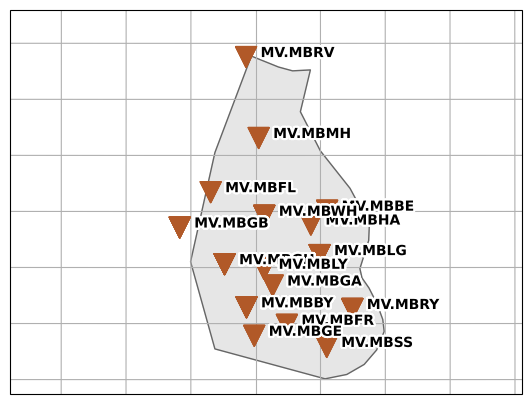

In [2]:
invMVO.plot(projection='local', resolution='f');

In [160]:
import numpy as np
import math
import matplotlib.pyplot as plt
from obspy.geodetics import locations2degrees, degrees2kilometers

class Grid:
    def __init__(self, centerlat, centerlon, nlat, nlon, node_spacing_m):
        deg2m = 111100
        node_spacing_lat = node_spacing_m / deg2m
        minlat = centerlat - (nlat-1)/2 * node_spacing_lat
        maxlat = centerlat + (nlat-1)/2 * node_spacing_lat
        latrange = [lat for lat in np.arange(minlat, maxlat+node_spacing_lat, node_spacing_lat)]
        node_spacing_lon = node_spacing_lat / np.cos(centerlat / (2 * math.pi))
        minlon = centerlon - (nlon-1)/2 * node_spacing_lon
        maxlon = centerlon + (nlon+1)/2 * node_spacing_lon
        lonrange = [lon for lon in np.arange(minlon, maxlon+node_spacing_lon, node_spacing_lon)]
        gridlon, gridlat = np.meshgrid(lonrange, latrange)
        self.gridlon = gridlon
        self.gridlat = gridlat
        self.node_spacing_lat = node_spacing_lat
        self.node_spacing_lon = node_spacing_lon
        self.lonrange = lonrange
        self.latrange = latrange

    def plot(self):
        plt.plot(self.gridlon, self.gridlat, marker='+', color='k', linestyle='none')
        plt.show()



class ASL:
    def __init__(self, samobject, metric, inventory, gridobj):
        ''' 
        ASL: Simple amplitude-based source location for volcano-seismic data 
        This program takes a VSAM, VSEM, or DSAM object as input
        Then armed with an inventory that provides station coordinates, it attempts
        to find a location for each sample by reducing amplitudes based on the grid
        node to station distance. Grid nodes are contained in a Grid object.

        ASL can use any one of the mean, max, median, VLP, LP, or VT metrics from a VSAM or DSAM object,
        or the energy metric from a VSEM object.

        '''

        if isinstance(samobject, VSAM) or isinstance(samobject, DSAM):
            datatype = 'amplitude'
        elif isinstance(samobject, VSEM):
            datatype = 'energy'
        else:
            print('invalid type passed as samobject. Aborting')
            return

        self.samobject = samobject
        self.metric = metric
        self.inventory = inventory
        self.gridobj = gridobj
        self.node_distances_km = {}
        self.station_coordinates = {}
        self.amplitude_corrections = {}

    def setup(self, surfaceWaves=False):  
        self.compute_grid_distances()
        self.compute_amplitude_corrections(surfaceWaves = surfaceWaves)

    def compute_grid_distances(self):
        st = self.samobject.to_stream()
        coordinates = {}
        node_distances_km = {}
        for tr in st:
            d_list = []
            try:
                coordinates[tr.id] = self.inventory.get_coordinates(tr.id)
                stalat = coordinates[tr.id]['latitude']
                stalon = coordinates[tr.id]['longitude']
                #print(tr.id, stalat, stalon)
            except Exception as e:
                #print(e)
                continue
            gridlat = self.gridobj.gridlat.reshape(-1)
            gridlon = self.gridobj.gridlon.reshape(-1)
            nodelatlon = zip(gridlat, gridlon)
            distances = [locations2degrees(nodelat, nodelon, stalat, stalon) for nodelat, nodelon in nodelatlon]       
            node_distances_km[tr.id] = [degrees2kilometers(thisdistance) for thisdistance in distances]
            #print('node_distances_km')
            #print(node_distances_km[tr.id])
        self.node_distances_km = node_distances_km
        self.station_coordinates = coordinates 

    def compute_amplitude_corrections(self, surfaceWaves=False, Q=None):
        #st = self.samobject.to_stream()
        corrections = {}
        if surfaceWaves:
            wavespeed_kms = 2
        else:
            wavespeed_kms = 3
        
        for seed_id, df in self.samobject.dataframes.items():
            if self.metric in ['mean', 'median', 'max', 'energy']:
                ratio = df['VT'].sum()/df['LP'].sum()
                peakf = np.sqrt(ratio) * 4
            elif self.metric == 'VLP':
                peakf = 0.1
            elif self.metric == 'LP':
                peakf = 2.0
            elif self.metric == 'VT':
                peakf = 8.0
            wavelength_km = peakf * wavespeed_kms
            if surfaceWaves and seed_id[-2]=='H':
                gsc = np.sqrt(node_distances_km[seed_id] * wavelength_km)
            else:
                gsc = self.node_distances_km[seed_id]
            #print(seed_id, gsc)
            if Q:
                t = self.node_distances_km[seed_id] / wavespeed_kms
                iac = np.power(math.e, math.pi * peakf * t * Q)
                corrections[seed_id] = np.multiply(gsc, iac)
            else:
                corrections[seed_id] = gsc
            #print(corrections[seed_id])
        self.amplitude_corrections = corrections
            
            
    
    def locate(self):
        gridlat = self.gridobj.gridlat.reshape(-1)
        gridlon = self.gridobj.gridlon.reshape(-1)
        st = self.samobject.to_stream(metric=self.metric)
        seed_ids = [tr.id for tr in st]
        lendata = len(st[0].data)
        #print(seed_ids[0])
        #print(self.amplitude_corrections)
        corrections = self.amplitude_corrections[seed_ids[0]]
        #print(len(corrections))
        #print(self.amplitude_corrections[seed_ids[0]])
        locations = []
        t = [t.datetime for t in st[0].times('utcdatetime')]
        for i in range(lendata): # loop ovder time samples
            y = [tr.data[i] for tr in st] # (len(st), 1)
            reduced_y = []
            misfit = []
            best_j = -1
            best_misfit = 1e10
            for j in range(len(corrections)): # loop over nodes
                # assume source is at grid node j
                c = [self.amplitude_corrections[id][j] for id in seed_ids] # corrections for this node (len(st), 1)
                if self.metric=='energy':
                    c = np.multiply(c,c)
                #print(c)
                reduced_y = np.multiply(y, c) # correcting everything to 1 km distance for all seed ids
                this_misfit = np.nanstd(reduced_y)/np.nanmedian(reduced_y)
                #print(this_misfit)
                if this_misfit < best_misfit:
                    best_misfit = this_misfit
                    best_j = j
                misfit.append(this_misfit)
            locations.append( (t[i], gridlat[best_j], gridlon[best_j]) )  
        return locations
        # Here is where i would add loop over shrinking grid

    import matplotlib.pyplot as plt
    @staticmethod
    def plot(locations):
        lat = [locations[i][1] for i in range(len(locations))]
        lon = [locations[i][2] for i in range(len(locations))]
        t = [locations[i][0] for i in range(len(locations))]
        plt.figure()
        plt.plot(lon, lat, '.')
        plt.figure()
        plt.plot(t, lon, '.')   
        plt.figure()
        plt.plot(t, lat, '.')

In [161]:
import os
import sys
import glob
import pandas as pd
import obspy
sys.path.append('../lib')
import setup_paths
paths = setup_paths.paths
from SAM import VSAM        
startt2 = obspy.UTCDateTime(2003,7,12,23,0,0)
endt2 = obspy.UTCDateTime(2003,7,13,5,0,0)
vsamObj2 = VSAM.read(startt2, endt2, SAM_DIR=paths['SAM_DIR'], sampling_interval=60, ext='pickle', \
                     trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'])      
source = {'lat':16.71111, 'lon':-62.17722}
nlat = 21
nlon = 11
node_spacing_m = 100
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  
#print(gridobj.gridlat)
#print(gridobj.gridlon)

In [162]:
#invMVO = None # SCAFFOLD
#vsamobj = None # SCAFFOLD
aslobj = ASL(vsamObj2, 'median', invMVO, gridobj)
aslobj.compute_grid_distances()
aslobj.compute_amplitude_corrections(surfaceWaves=False)

In [163]:
#print(aslobj.amplitude_corrections)
#print(aslobj.gridobj.latrange)
locations = aslobj.locate()

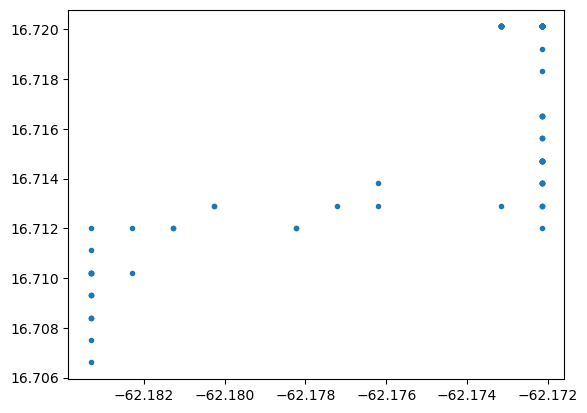

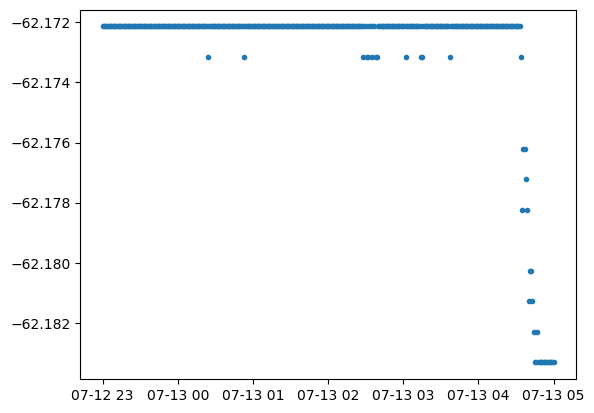

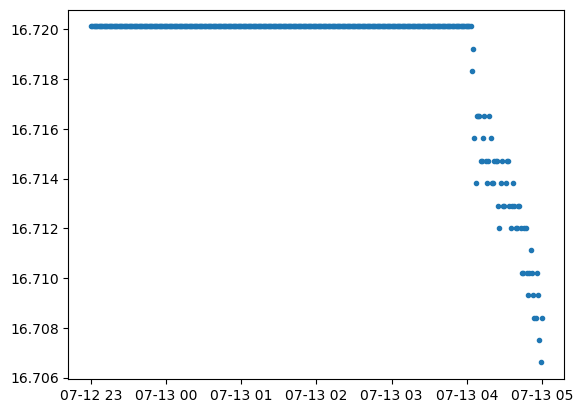

In [164]:
aslobj.plot(locations)

METRIC:  mean


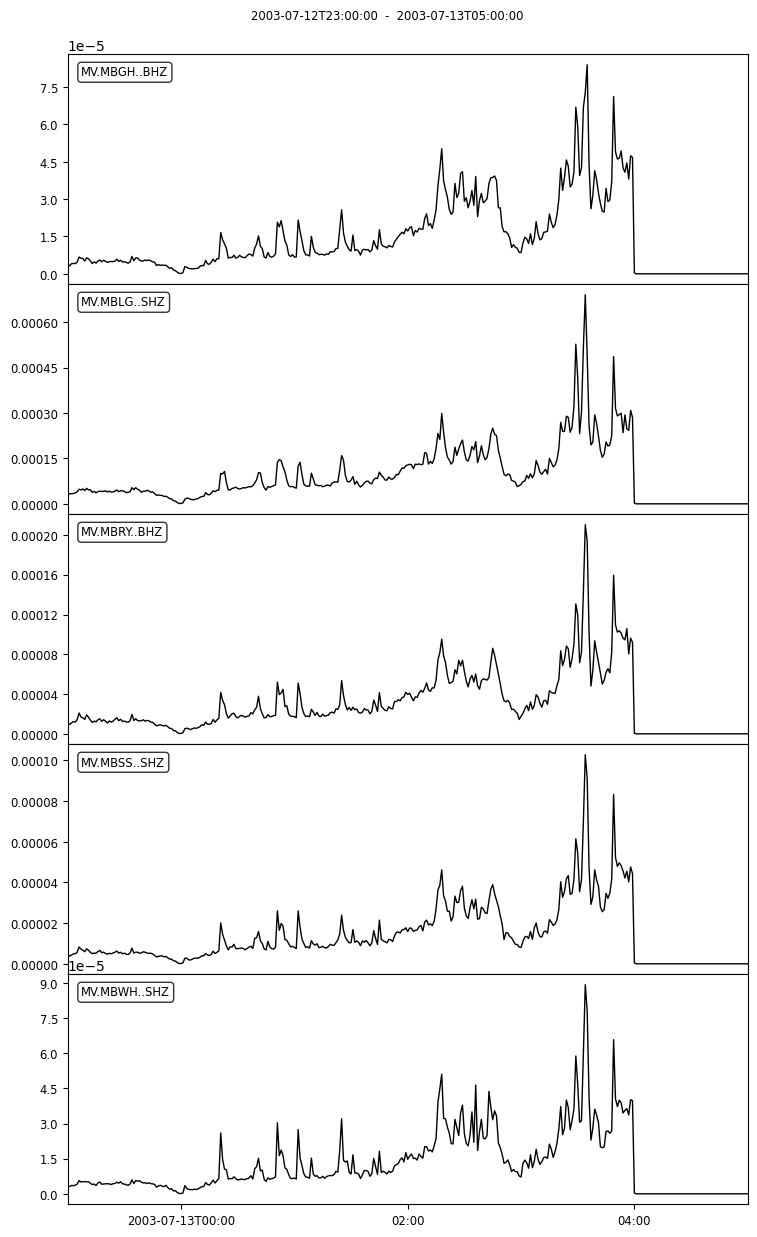

In [158]:
vsamObj2.plot()

In [25]:
a = np.array([[1, 2, 3, 4],])
b= np.array([10, 100, 1000, 0])
print(a * b.transpose())

[[  10  200 3000    0]]


In [67]:
d, az1, az2 = gps2dist_azimuth([62.5, 63.4], [-130.1, -128.7], [62.8, 62.8], [-130.5, -130.5]) 

TypeError: '>' not supported between instances of 'list' and 'int'

In [65]:
print(d,az1,az2)

39226.59755907678 328.650984040618 148.29569585806595


In [68]:
import geopy

ModuleNotFoundError: No module named 'geopy'